In [1]:
import csv
import numpy as np 
import random
import time
# sve_ivp
import os
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})
from Update_LM_functions import calculate_constraints, update_lambda, openfile
from PredictionFunctions import cell_pred_fn

on_mac = True 
on_thinkpad = False 
on_hpg = False

In [2]:
if on_mac == True: 
    data_path = "/Volumes/hodaakl/"
if on_thinkpad== True: 
    data_path = "//exasmb.rc.ufl.edu/blue/pdixit/hodaakl/"
if on_hpg == True: 
    data_path = "/blue/pdixit/hodaakl/"

# specify the project you are working on     
spec_folder = data_path + 'A5MCMC_IGF_FoxO/'

In [3]:

def read_csv( path , index = 0, dat = 'cellpreds' ): 
    if dat == 'cellpreds':
        fn = path + f'cellpreds_{index}.csv'
    if dat == 'moments':
        fn = path + f'moments_{index}.csv'
    if dat == 'lambdas':
        fn = path + f'Lambdas.csv'
    if dat == 'params': 
        fn = path + f'params_{index}.csv'  
    if dat == 'variance': 
        
        fn = path + f'variance_{index}.csv'
    
    df = pd.read_csv(fn, sep = ',', header = None) 
    
    table = df.to_numpy()
    return table
    

### Comparing the means and the second moment of the simulation to the data 
1.  ✅Load the parameters of the iteration I want to examine 
2.  ✅from the parameters get the mean and the variance of the cells  (ran on hpg )
3.  compare with the experimental data

In [6]:
# 1. Loading the parameters 


folder_out ='0403_test4/' #    Lambda = old_lambda.copy() + alpha_arr*(Error)/true_constraints
path = spec_folder + folder_out

# get the best iteration 
err_fn = path +  'Errors.csv'
df = pd.read_csv(err_fn, sep = ',', header = None , ) 
err_np = df.to_numpy()
mean_err = np.mean(abs(err_np), axis = 1)
Best_iteration = np.argmin(mean_err)
print(Best_iteration)

# load the parameters 
param_np = read_csv(path = path, index = Best_iteration, dat = 'params')
print(param_np.shape)





278
(20315, 14)


In [12]:
# 2. Get the means and the 2nd moment of the cells 

# determining the conditions 
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nConds = int(len(times_arr)*len(L))

# initializing the data matrix 
nC, nP = param_np.shape 
mu_mat = np.empty((nC, nConds))
s_mat  = np.empty((nC, nConds))
v_mat  = np.empty((nC, nConds))

# for each cellular parameters, get the mean and the variance , obtain the second moment from the variance 
for i in range(nC):
    k = param_np[i,:]
    mu, var = cell_pred_fn(k, times_arr, L)
    mu_mat[i,:] = mu
    v_mat[i,:]  = var
    s_mat[i,:]  = var + mu**2
    
    if i%1000==0:
        print(f'at cell {i}')
    

at cell 0


KeyboardInterrupt: 

In [15]:
np.save(f'mu_mat_iter{Best_iteration}.npy',mu_mat)
np.save(f'SecondMoment_mat_iter{Best_iteration}.npy',mu_mat)
np.save(f'Var_mat_iter{Best_iteration}.npy',mu_mat)




In [7]:
## load those matrices

folder_out ='0403_test4/' #    Lambda = old_lambda.copy() + alpha_arr*(Error)/true_constraints
path = spec_folder + folder_out
mu_mat = np.load(path + 'mu_mat_iter278.npy')
s_mat = np.load(path + 'SecondMoment_mat_iter278.npy')
var_mat = np.load(path + 'Var_mat_iter278.npy')

In [8]:
# load the means and the second moments of the data from the constraint dictionary saved befr

MuS_consDict = np.load(spec_folder + 'Arrays_for_max_ent/Cons_1213_MuS.npy', allow_pickle=True).item()


In [67]:
## compare the results 
ax = 0

Mu_Pop = np.mean(mu_mat, axis = ax)
print(Mu_Pop.shape)
S_Pop = np.mean(s_mat, axis = ax)

(28,)


In [69]:
Mu_max = np.max(mu_mat, axis = ax)

Mu_max

array([3070.60026538, 3069.85065284, 3068.38079193, 3065.56581575,
       3062.87189623, 3062.09637784, 3061.58913929, 3070.60026538,
       3069.4761615 , 3067.27279009, 3063.05537205, 3059.02301501,
       3057.86286941, 3057.10427387, 3070.60026538, 3069.1019135 ,
       3066.16593512, 3060.54971519, 3055.18418162, 3053.64224796,
       3052.63358832, 3070.60026538, 3066.86051117, 3059.54869013,
       3045.61149525, 3032.36181875, 3028.57261852, 3026.09066907])

In [10]:
Mu_Pop

array([497.37196189, 486.55347784, 468.37371318, 440.41554171,
       415.59903172, 407.08102131, 398.97510312, 497.37196189,
       481.66015181, 456.42641511, 419.71549114, 389.22926837,
       379.31495801, 370.26837774, 497.37196189, 477.03850394,
       445.63270332, 401.97790135, 367.62195718, 356.93567058,
       347.51756175, 497.37196189, 453.45287861, 396.2127275 ,
       330.23360174, 288.54076018, 277.72324158, 269.36646031])

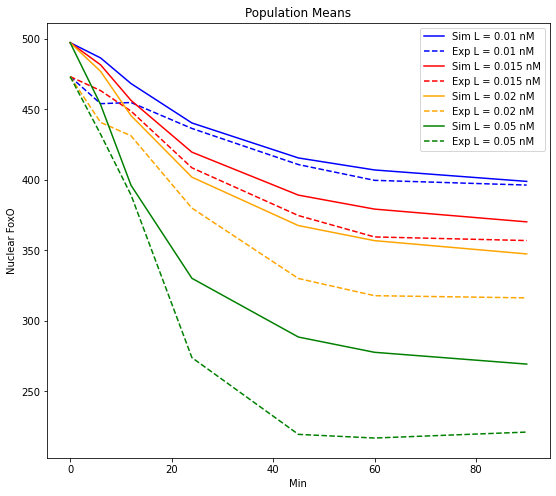

In [45]:
fig, axis = plt.subplots(figsize = (9,8))
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
c = ['b','r','orange','g','k','purple']
# means_sim_conc = np.array([])
i=0
for li in range(nL):
    plt.plot(times_arr/60, Mu_Pop[i:i+nT], label = f'Sim L = {L[li]} nM', c=c[li])
    plt.plot(times_arr/60, MuS_consDict['array'][i:i+nT], '--', label = f'Exp L = {L[li]} nM', c=c[li])
    
    
    i+=nT

plt.title('Population Means')
plt.xlabel('Min')
plt.ylabel('Nuclear FoxO')
plt.legend()

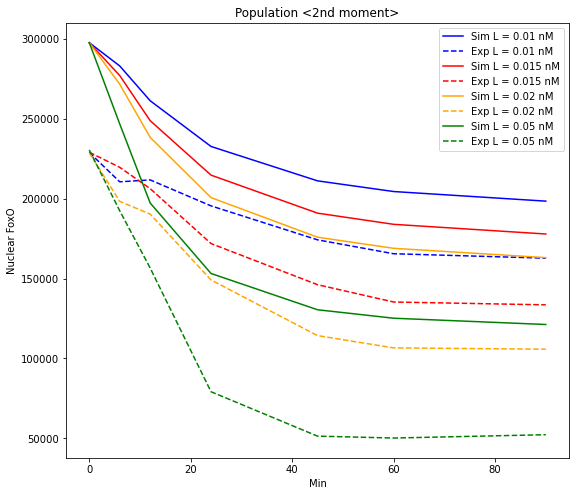

In [47]:
fig, axis = plt.subplots(figsize = (9,8))
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
f = nConds
c = ['b','r','orange','g','k','purple']
i=0
for li in range(nL):
    plt.plot(times_arr/60, S_Pop[i:i+nT], label = f'Sim L = {L[li]} nM', c=c[li])
    plt.plot(times_arr/60, MuS_consDict['array'][f+i:f+i+nT], '--', label = f'Exp L = {L[li]} nM', c=c[li])
    
    i+=nT

plt.title('Population <2nd moment>')
plt.xlabel('Min')
plt.ylabel('Nuclear FoxO')
plt.legend()

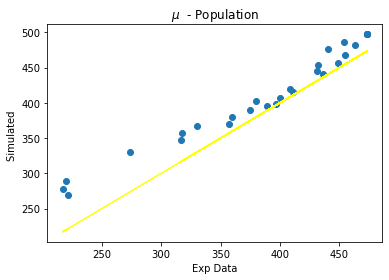

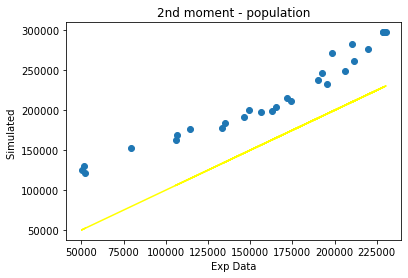

In [52]:
## plotting x against y 
plt.scatter( MuS_consDict['array'][:nConds]  ,Mu_Pop )
plt.plot(MuS_consDict['array'][:nConds], MuS_consDict['array'][:nConds], c = 'yellow')
plt.title(r'$\mu$  - Population')
plt.xlabel('Exp Data')
plt.ylabel('Simulated ')
plt.show()

plt.scatter(MuS_consDict['array'][nConds:], S_Pop)
plt.plot(MuS_consDict['array'][nConds:], MuS_consDict['array'][nConds:], c = 'yellow')
plt.xlabel('Exp Data')
plt.ylabel('Simulated ')
plt.title(r'2nd moment - population')




plt.show()

In [54]:
std_sim = np.sqrt(S_Pop - Mu_Pop**2)
mu_exp = MuS_consDict['array'][:nConds]
s_exp = MuS_consDict['array'][nConds:]

std_exp = np.sqrt(s_exp - mu_exp**2)

Text(0.5, 1.0, 'std - population')

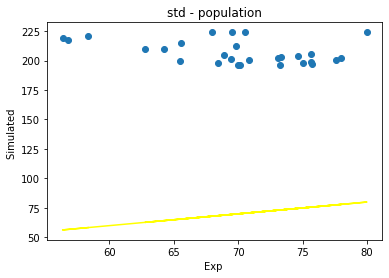

In [57]:
plt.scatter(std_exp, std_sim)
plt.plot(std_exp, std_exp, c = 'yellow')
plt.xlabel('Exp ')
plt.ylabel('Simulated ')
plt.title(r'std - population')

### Compare the cumulative distribution between both 

In [11]:
from collections import defaultdict
from scipy.stats import gamma 



In [12]:

boundsdict = np.load('Arrays_for_max_ent/pcon_dict_250222.npy', allow_pickle=True).item()
boundsdict['0.1']


array([386.75755122, 372.40782751, 369.21130508, 349.60543963,
       320.25776825, 306.24699081, 303.76340978, 385.5237622 ,
       376.47811512, 362.45957134, 321.69236245, 281.657033  ,
       264.38394875, 261.39181366, 388.57121543, 362.56985019,
       349.8281672 , 295.38311468, 240.55654211, 226.80302712,
       224.08278862, 374.14766873, 341.56687039, 301.73790835,
       195.49232158, 150.61726016, 148.53657874, 150.41805383])

In [43]:
DataDict = np.load('ProDataDict.npy', allow_pickle=True)
DataDict = DataDict.item()
time_values = [0,6,12,24,45,60,90] #minutes 
times_constrained = np.array(time_values) #minutes 

idx_list = np.array(times_constrained/3, dtype=int)
dist_gparams = defaultdict(lambda:'not present')
perc_arr = np.arange(.1,1,.1)
print(perc_arr)
pcl_dict = defaultdict(lambda:'not present') #percentile constraint dictionary
# pcl = [] #percentile constraint list 
for key in DataDict:
    # relevant data
    drel  = DataDict[key][idx_list,:]
    
    muarr = np.mean(drel, axis = 1)
    vararr = np.var(drel, axis = 1)
    
    alpha_arr = (muarr**2)/(vararr)
    scale_arr = vararr/muarr
    
    
    # dist_gparams[key] =  {'alphas' : alpha_arr, 'scales': scale_arr}
    
    for p in perc_arr: 
        pcl_dict[f'{key}_{np.round(p,2)}'] = gamma.ppf(p,alpha_arr , scale = scale_arr)
        
pcl_dict = dict(pcl_dict)  

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


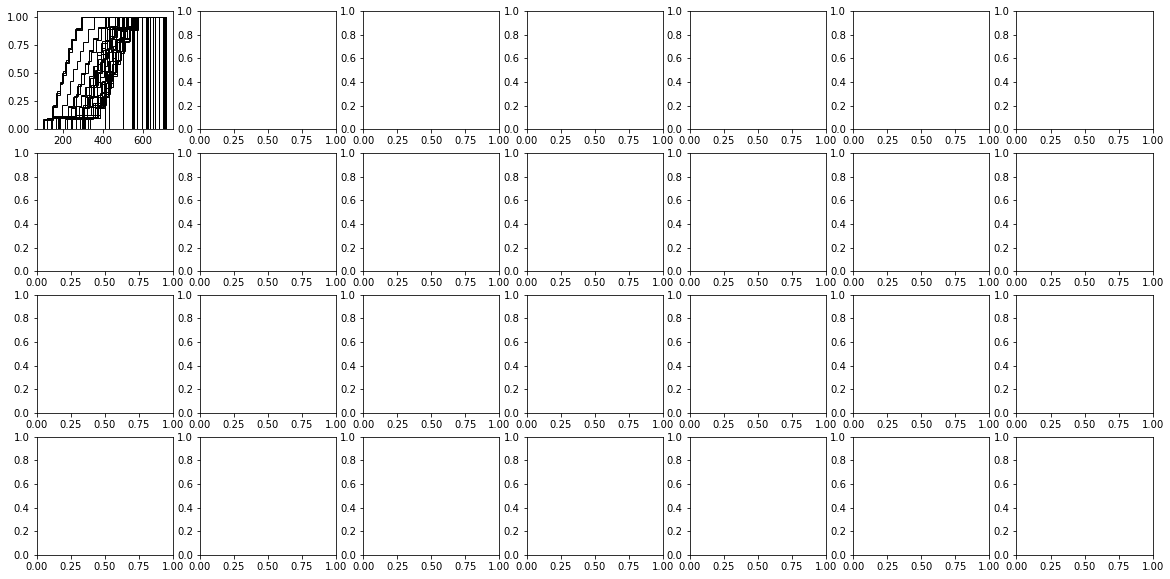

In [15]:
#  Check the error of those constraints ! 
# for each condition, draw the histogram defined by those boundaries 
time_values = [0,6,12,24,45,60,90] #minutes 
times_constrained = np.array(time_values) #minutes 

idx_list = np.array(times_constrained/3, dtype=int)
# dist_gparams = defaultdict(lambda:'not present')
perc_arr = np.arange(.1,1,.1)
print(perc_arr)
nT = len(time_values)


# pcl_dict = defaultdict(lambda:'not present') #percentile constraint dictionary
# pcl = [] #percentile constraint list
nR = len(DataDict)
fig, axs = plt.subplots(nR,nT, figsize = (20,10))
nr = 0; nc = 0;
exp_bins_dict = defaultdict(lambda:'not present')
for key in DataDict:
    # relevant data
    for ii in range(nT):
        # print(f'{key}_{times_constrained[ii]}min')
        drel  = DataDict[key][idx_list[ii],:]
        bins = np.zeros((len(perc_arr)+2))
        bins[0]=np.min(drel)
        bins[-1] = np.max(drel)
        for j in range(0,len(perc_arr)): 
            k = f'{key}_{np.round(perc_arr[j],2)}'
            # print(k)
            bins[j+1] = pcl_dict[k][ii]
        # print('bins:', bins)
        n, bins, patches = axs[nr, nc].hist(drel,edgecolor='black', bins=bins, cumulative = True, density=True, histtype='step')
        key2= f'{key}_{time_values[ii]}Min'
        exp_bins_dict[key2] = n
        
        
#         axs[nr, nc].set_title(f'{key}_{times_constrained[ii]}min')
#         axs[nr, nc].set_xlabel('nuclear FoxO')
#         axs[nr, nc].set_ylabel('count')
#         # plt.show()
#         nc+=1 
#         if nc==nT: 
#             nc=0
#             nr+=1 
# plt.tight_layout()

In [77]:
exp_bins_dict

defaultdict(<function __main__.<lambda>()>,
            {'10pM_0Min': array([0.10299003, 0.2192691 , 0.32890365, 0.41528239, 0.48837209,
                    0.60797342, 0.68106312, 0.81395349, 0.88372093, 1.        ]),
             '10pM_6Min': array([0.10631229, 0.2192691 , 0.33554817, 0.40863787, 0.51162791,
                    0.60797342, 0.70099668, 0.81727575, 0.90033223, 1.        ]),
             '10pM_12Min': array([0.10299003, 0.20598007, 0.3255814 , 0.40863787, 0.51495017,
                    0.63122924, 0.70431894, 0.80730897, 0.89368771, 1.        ]),
             '10pM_24Min': array([0.09302326, 0.21262458, 0.28903654, 0.42857143, 0.52159468,
                    0.61129568, 0.74418605, 0.79734219, 0.89700997, 1.        ]),
             '10pM_45Min': array([0.089701  , 0.19933555, 0.29900332, 0.41860465, 0.51495017,
                    0.63122924, 0.72093023, 0.81727575, 0.88039867, 1.        ]),
             '10pM_60Min': array([0.09966777, 0.19601329, 0.29568106, 0.395348

In [16]:
## percentiles 
cellpreds_np = read_csv(path = path, index = Best_iteration)#, dat = 'cell_preds')



In [21]:
cellpreds_np.shape

(20315, 252)

In [20]:
times_arr = np.array([ 0,  6, 12, 24, 45, 60, 90])*60 #make it in seconds 
L  = np.array([10,15,20,50])*10**-3 #make it in nM
nT = len(times_arr)
nL = len(L)
nConds = int(nT*nL)
perc_arr = np.arange(.1,1,.1)
print(perc_arr)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [22]:
cpmean = np.mean(cellpreds_np, axis =0)
cpmean.shape

(252,)

In [23]:
nppc = 9 

Per_Mat = np.empty((nppc,nConds ))
k=0
for i in range(nppc):
    Per_Mat[i,:] = cpmean[k:k+nConds]
    k+=nConds
    
# for i in nConds: 
#     for pi in range(len(perc_arr)):
# Per_Mat    

In [24]:
cum_mat = np.empty_like(Per_Mat)


for i in range(nppc-1):
    cum_mat[i,:] = np.sum(Per_Mat[0:i+1,:], axis = 0)
    
cum_mat[-1,:]  = np.sum(Per_Mat, axis = 0)

In [54]:
Bound_dict_cond = defaultdict(lambda: 'not present')

for conc_key in DataDict:
    for ii in range(nT):
        cond_key= f'{conc_key}_{time_values[ii]}Min'
        Bound_dict_cond[cond_key] = np.array([]) 
        
        for pi in perc_arr:
            pi = np.round(pi, 2)
            pk = f'{conc_key}_{pi}'
            
#             print(pk)
#         # key1= f'{key}_'
#             print(pcl_dict[pk][ii])
#             print(np.array(pcl_dict[pk][ii]))
            Bound_dict_cond[cond_key] = np.concatenate((Bound_dict_cond[cond_key], np.array([pcl_dict[pk][ii]])) , axis =0 )

# pcl_dict
Bound_dict_cond = dict(Bound_dict_cond)

In [58]:
Bound_dict_cond['10pM_0Min'].shape

(9,)

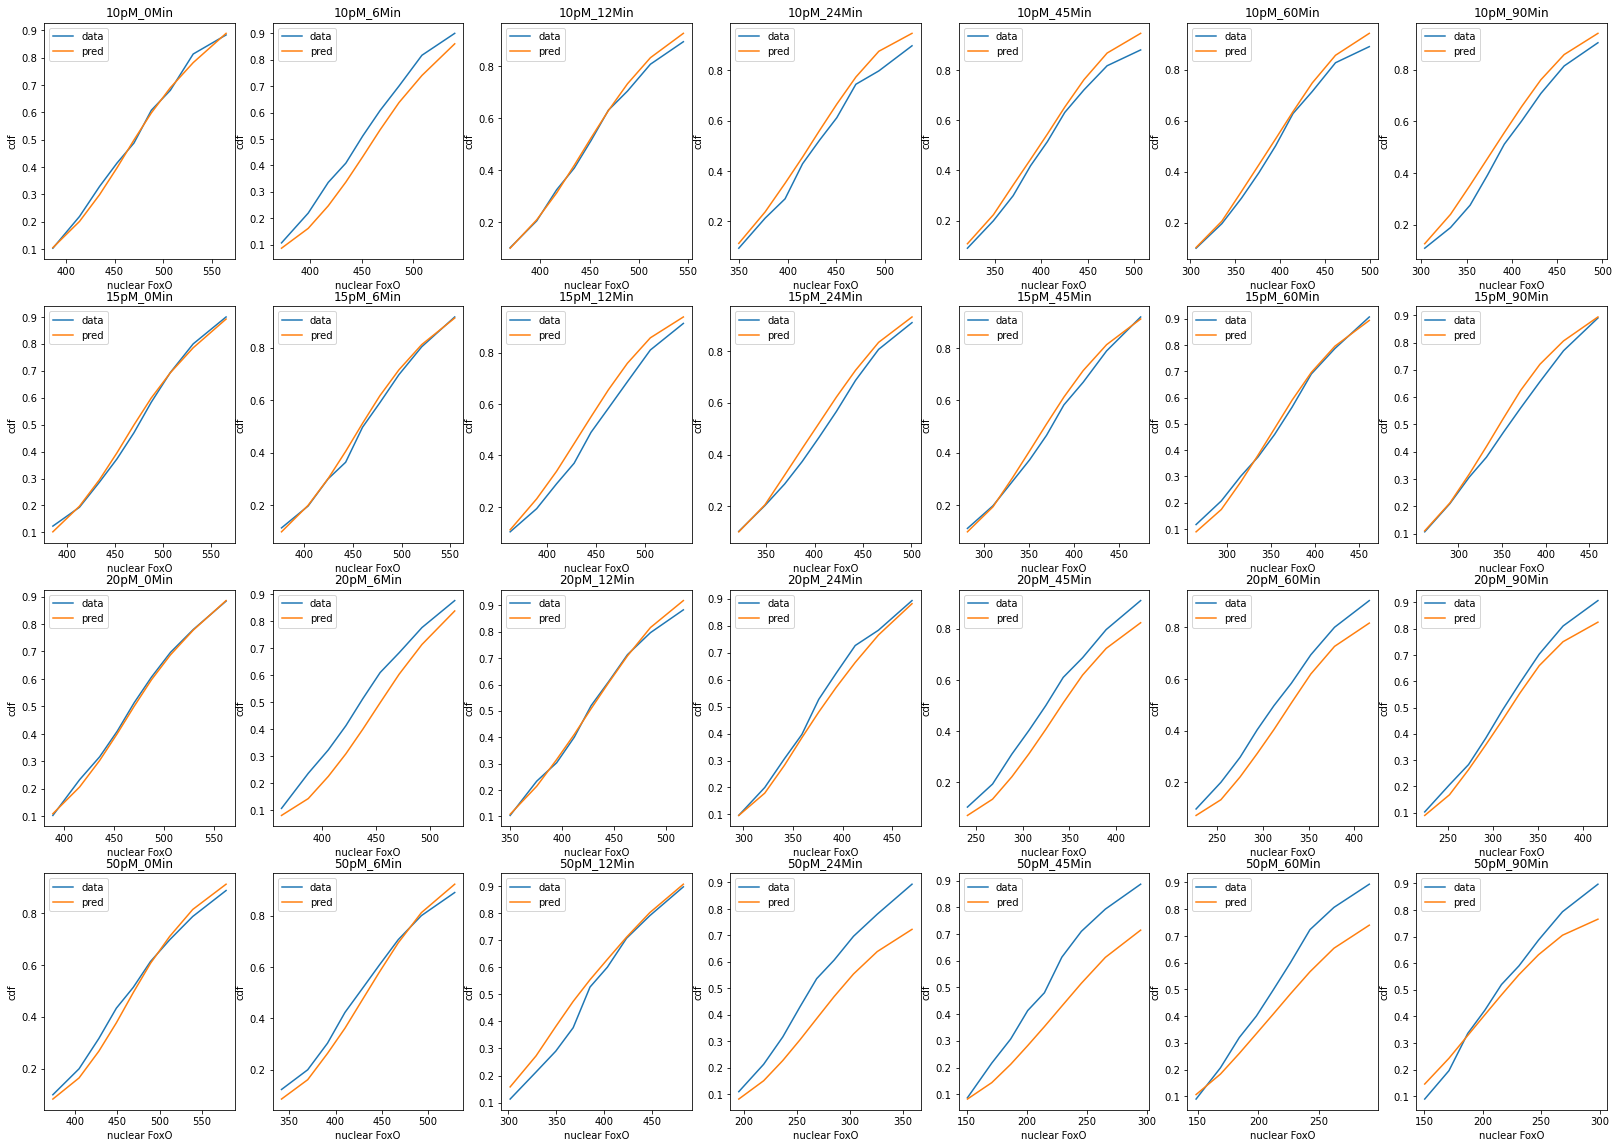

In [66]:
nR = len(DataDict)
fig, axs = plt.subplots(nR,nT, figsize = (28,20))
# nT = len(time_values)
nr = 0; nc = 0;
i=0
for key in DataDict:
    for ii in range(nT):
        key2= f'{key}_{time_values[ii]}Min'


        axs[nr,nc].plot(Bound_dict_cond[key2],exp_bins_dict[key2][:-1], label = 'data')

        axs[nr,nc].plot(Bound_dict_cond[key2], cum_mat[:,i], label = 'pred')
        
        
        axs[nr, nc].set_title(f'{key2}')
        axs[nr, nc].set_xlabel('nuclear FoxO')
        axs[nr, nc].set_ylabel('cdf')
        
        # if (nr==0 and nc==0):
            
        axs[nr, nc].legend()
    
    
        i+=1 
        nc+=1 
        
        if nc==nT:
            nc=0
            nr+=1
plt.show()

In [104]:
exp_bins_dict[key]

array([0.09      , 0.19666667, 0.33666667, 0.42333333, 0.52      ,
       0.59      , 0.68666667, 0.79333333, 0.89666667, 1.        ])